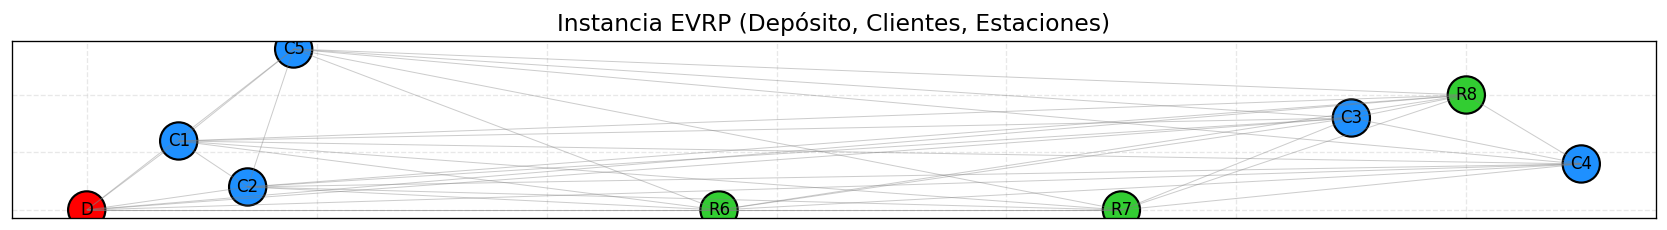

In [18]:
import math
import networkx as nx
import matplotlib.pyplot as plt


def load_evrp_instance(path):
    with open(path, "r") as f:
        tokens = f.read().split()
    tokens = list(map(float, tokens))  # por si algún día hay parámetros no enteros

    it = iter(tokens)

    # 1) Parámetros "globales"
    B = int(next(it))       # número de vehículos
    Q = float(next(it))     # capacidad de cada vehículo
    B_max = float(next(it)) # autonomía máxima

    C_km = float(next(it))  # costo por km
    C_rec = float(next(it)) # costo por recarga

    P = int(next(it))       # número de clientes
    S = int(next(it))       # número de estaciones

    # 2) Demandas
    demands = [float(next(it)) for _ in range(P)]

    # 3) N nodos y sus coordenadas
    N = int(next(it))
    coords = [(float(next(it)), float(next(it))) for _ in range(N)]

    data = {
        "B": B,
        "Q": Q,
        "B_max": B_max,
        "C_km": C_km,
        "C_rec": C_rec,
        "P": P,
        "S": S,
        "demands": demands,
        "N": N,
        "coords": coords,
    }
    return data


def build_graph_from_instance(data):
    N = data["N"]
    P = data["P"]
    coords = data["coords"]

    G = nx.Graph()

    # Añadimos nodos con atributos
    for i in range(N):
        if i == 0:
            node_type = "depot"
        elif 1 <= i <= P:
            node_type = "client"
        else:
            node_type = "station"

        G.add_node(
            i,
            pos=coords[i],
            type=node_type,
        )

    # Añadimos aristas completas con peso = distancia euclidiana
    for i in range(N):
        xi, yi = coords[i]
        for j in range(i + 1, N):
            xj, yj = coords[j]
            dist = math.hypot(xi - xj, yi - yj)
            cost = dist * data["C_km"]  # si quieres costo en vez de distancia

            G.add_edge(i, j, distance=dist, cost=cost)

    return G

def plot_evrp_graph(G):
    import matplotlib.pyplot as plt
    from matplotlib.collections import LineCollection

    pos = nx.get_node_attributes(G, "pos")

    # Colores y etiquetas
    colors = []
    labels = {}
    for n, attrs in G.nodes(data=True):
        t = attrs["type"]
        if t == "depot":
            colors.append("red")
            labels[n] = "D"
        elif t == "client":
            colors.append("dodgerblue")
            labels[n] = f"C{n}"
        else:
            colors.append("limegreen")
            labels[n] = f"R{n}"

    fig, ax = plt.subplots(figsize=(14, 4), dpi=120)


    # --- Dibujar nodos ---
    nx.draw_networkx_nodes(
        G, pos, node_color=colors, edgecolors="black",
        linewidths=1.3, node_size=500, ax=ax
    )

    # --- Dibujar edges manualmente para tener pickability real ---
    segments = []
    edges_list = list(G.edges())
    for u, v in edges_list:
        x0, y0 = pos[u]
        x1, y1 = pos[v]
        segments.append([(x0, y0), (x1, y1)])

    lc = LineCollection(
        segments,
        colors="gray",
        linewidths=0.6,
        alpha=0.4
    )
    ax.add_collection(lc)
    lc.set_picker(True)

    # --- Labels ---
    nx.draw_networkx_labels(G, pos, labels, font_size=10, ax=ax)

    # --- Grid mejorado ---
    ax.grid(True, linestyle="--", color="lightgray", alpha=0.5)
    ax.set_axisbelow(True)

    ax.set_aspect("equal", adjustable="box")
    ax.set_title("Instancia EVRP (Depósito, Clientes, Estaciones)", fontsize=14)

    # --- Tooltip dinámico ---
    annot = ax.annotate(
        "",
        xy=(0, 0),
        xytext=(10, 10),
        textcoords="offset points",
        bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.8),
        arrowprops=dict(arrowstyle="->"),
    )
    annot.set_visible(False)

    def on_pick(event):
        if event.artist != lc:
            return

        idx = event.ind[0]
        u, v = edges_list[idx]
        dist = G[u][v]["distance"]

        mx = event.mouseevent.xdata
        my = event.mouseevent.ydata
        if mx is None:
            return

        annot.xy = (mx, my)
        annot.set_text(f"{u}–{v}\nDist: {dist:.2f}")
        annot.set_visible(True)
        fig.canvas.draw_idle()

    fig.canvas.mpl_connect("pick_event", on_pick)

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # 1) Cargar instancia
    data = load_evrp_instance("instancias/instancia7.txt")

    # 2) Construir grafo
    G = build_graph_from_instance(data)

    # 3) Plotear (interactivo)
    plot_evrp_graph(G)
